In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
SPLITING_DATE = '2016-02-21'
MOVING_AVERAGE_WINDOW = 1

In [4]:
table_cardio = pd.read_csv("cardio_table.csv")
table_cardio['START'] = table_cardio['AVAILABILITY_START_DATE'].map(lambda x: str(x).split()[0])
table_cardio['END'] = table_cardio['REMOVEDATE'].map(lambda x: str(x).split()[0])
table_cardio.head()

,DAY_,KUST_ID,MEDICAL_EMPLOYEE_JOB_INFO_ID,AVAILABLE_RESOURCE_ID,AVAILABILITY_START_DATE,REMOVEDATE,TOTAL,BUSY,START,END
0,02-FEB-15,175,14945,1223,01-FEB-08 12.00.00.000000000 AM,09-SEP-15 04.31.19.901456000 PM,24,18,01-FEB-08,09-SEP-15
1,06-MAR-15,175,14945,1223,01-FEB-08 12.00.00.000000000 AM,09-SEP-15 04.31.19.901456000 PM,22,20,01-FEB-08,09-SEP-15
2,13-FEB-15,10000239,10000864,10001805,01-FEB-08 12.00.00.000000000 AM,15-MAY-15 05.40.01.682309000 PM,18,18,01-FEB-08,15-MAY-15
3,25-MAR-15,10000239,10000864,10001805,01-FEB-08 12.00.00.000000000 AM,15-MAY-15 05.40.01.682309000 PM,16,15,01-FEB-08,15-MAY-15
4,23-MAR-15,10000239,10000864,10001805,01-FEB-08 12.00.00.000000000 AM,15-MAY-15 05.40.01.682309000 PM,16,16,01-FEB-08,15-MAY-15


### Человек-куст =)

In [5]:
patient_kust = pd.read_csv('person_kust_birth.csv', sep=';')

In [5]:
patient_kust.head(10)

,emiasid,date_birth,kust_id
0,16834760,16.11.1969,204
1,26987829,16.12.1987,10000430
2,19043484,16.04.2003,NaN
3,803384666,28.04.1974,145
4,19267466,07.04.1943,10000395
5,19505393,18.10.1975,10000402
6,26074092,19.02.1956,10491203
7,1080178741,07.11.1963,141
8,1635597541,17.08.1957,10000287
9,1739981491,17.10.1946,10146803


### Исключаем слоты супер-кардиологов

In [7]:
super_cardiologs_list = [14226272, 10444023, 14105340, 14094046]
table_cardio[table_cardio['AVAILABLE_RESOURCE_ID'].isin(super_cardiologs_list)]
av_r_id_dict ={}
for av_r_id in super_cardiologs_list:
    av_r_id_dict[av_r_id] = table_cardio[table_cardio['AVAILABLE_RESOURCE_ID'] == av_r_id].KUST_ID.unique()

av_r_id_dict = {k: av_r_id_dict[k][0] for k in av_r_id_dict}
av_r_id_dict

{10444023: 204, 14094046: 10000370, 14105340: 145, 14226272: 10000430}

In [ ]:
superCardKusts = av_r_id_dict.values()
superCardKusts

[10000430, 145, 10000370, 204]

In [ ]:
temp = None
for card_id in super_cardiologs_list:
    temp = table_cardio.drop((table_cardio.AVAILABLE_RESOURCE_ID == card_id) &\
     (pd.to_datetime(table_cardio['DAY_']) >= pd.to_datetime(table_cardio.START)) &\
              ((pd.to_datetime(table_cardio['DAY_']) <= pd.to_datetime(table_cardio.END)) | 
              (pd.to_datetime(table_cardio.END).isnull())))

In [ ]:
table_cardio = temp

In [6]:
def make_table_with_flow_data(input_table):
    df = input_table[['DATE', 'BUSY', 'TOTAL', 'AVAILABLE_RESOURCE_ID', 'KUST_ID', 'DATE_WEEK']]
    gr = df.groupby('DATE_WEEK')
    
    df.index = df.DATE
    del df['DATE']
    
    res = gr.agg({'TOTAL': lambda x: np.sum(x),
                              'BUSY': lambda x: np.sum(x)})

    res['FREE_PERCENT'] = (res['TOTAL'] - res['BUSY']) / res['TOTAL']
    res['FREE'] = res['TOTAL'] - res['BUSY']
    reset_res = res.reset_index()
    reset_res.index = reset_res.DATE_WEEK
    return df, reset_res

def split_train_test(input_table, spliting_date, start_date='2015-01-01', end_date='2016-08-01'):
    test = input_table[(input_table.DATE > pd.Timestamp(spliting_date)) & \
                                (input_table.DATE <= pd.Timestamp(end_date))]
    train = input_table[(input_table.DATE < pd.Timestamp(spliting_date)) & (input_table.DATE >= pd.Timestamp(start_date))]
    
    df_train, aggByDateWeek_train = make_table_with_flow_data(train)
    df_test, aggByDateWeek_test = make_table_with_flow_data(test)
    
    return {'test': {'aggregated': aggByDateWeek, 'original': df_test}, \
            'train': {'aggregated': aggByDateWeek, 'original': df_test}}

In [7]:
table_cardio['DATE'] = pd.to_datetime(table_cardio['DAY_'])
table_cardio.index = table_cardio['DATE']
table_cardio = table_cardio.sort_index()
table_cardio = table_cardio[table_cardio['DATE'] < pd.Timestamp('2016-08-01')]

initial_date = pd.Timestamp('2015-01-01')
temp_var = table_cardio.DATE.map(lambda x: initial_date + timedelta(days= 7 * ((x - initial_date).days / 7)))

table_cardio['DATE_WEEK'] = temp_var

In [8]:
table_cardio_test = table_cardio[(table_cardio.DATE > pd.Timestamp(SPLITING_DATE)) & \
                                (table_cardio.DATE <= pd.Timestamp('2016-08-01'))]
table_cardio_train = table_cardio[table_cardio.DATE <= pd.Timestamp(SPLITING_DATE)]

df_train, reset_res_train = make_table_with_flow_data(table_cardio_train)
df_test, reset_res_test = make_table_with_flow_data(table_cardio_test)
df, reset_res = make_table_with_flow_data(table_cardio)

### Понедельное количество слотов в течение всего времени измерения

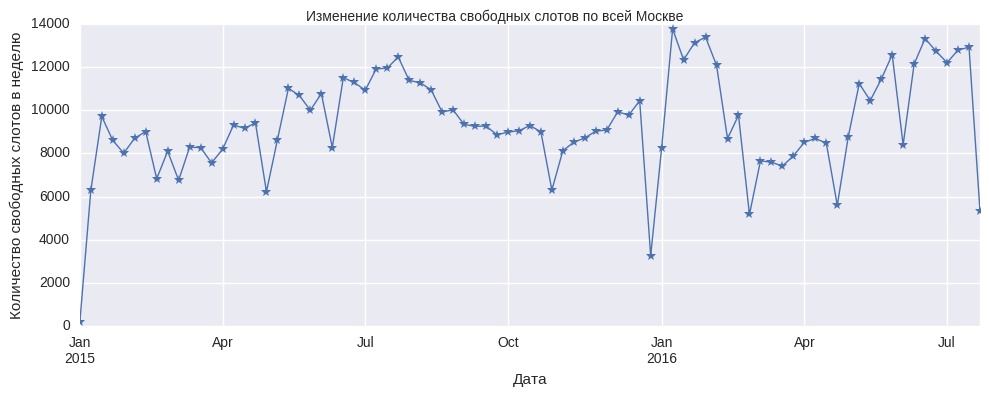

In [142]:
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)

freeSeries = pd.Series(reset_res["FREE"]).sort_index()
freeSeries = pd.rolling_mean(freeSeries, window=MOVING_AVERAGE_WINDOW)
# freeSeries = freeSeries[1:-1]
pd_ax = freeSeries.plot(ax=ax, style='*-', label='first line', linewidth=1)

pd_ax.set_xlabel(u'Дата')
pd_ax.set_ylabel(u'Количество свободных слотов в неделю')
plt.suptitle(u'Изменение количества свободных слотов по всей Москве')
plt.savefig('./GRAPHS/Free_slots_over_Moscow.png')

### Проверяем наличие тренда

In [10]:
import statsmodels.formula.api as smf
regression_series = pd.DataFrame({'VAL':freeSeries.values, 'DAYS': (freeSeries.index - pd.Timestamp('2015-01-01')) \
                                  .astype('timedelta64[D]')})
smf.ols( 'VAL ~ DAYS', data=regression_series).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    VAL   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     6.744
Date:                Fri, 16 Sep 2016   Prob (F-statistic):             0.0112
Time:                        18:10:37   Log-Likelihood:                -758.08
No. Observations:                  83   AIC:                             1520.
Df Residuals:                      81   BIC:                             1525.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8301.0473    493.448     16.823      0.000      7319.241  9282.854
DAYS           3.8549      1.484      2.597      0.011         0.901     6.809
==============================================================================
Omnibus:                       15.757   Durbin-Watson:                   0.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.327
Skew:                          -0.915   Prob(JB):                     6.36e-05
Kurtosis:                       4.497   Cond. No.                         659.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Это означает, что тренда нет

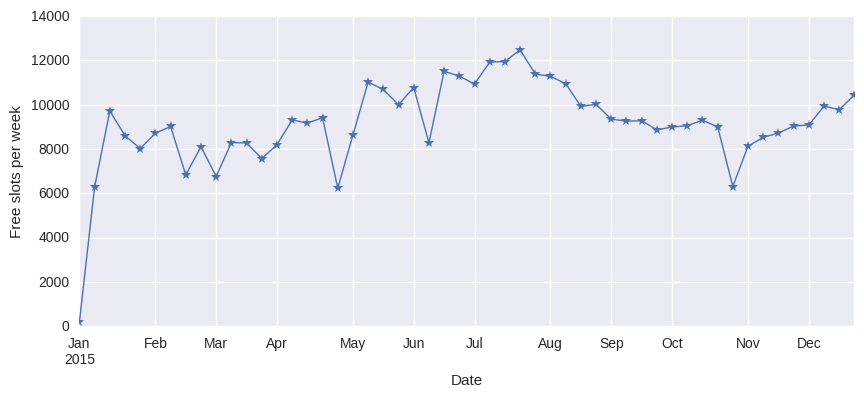

In [11]:
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)

reset_res_2015 = reset_res[reset_res.index < pd.Timestamp('2015-12-30')]
freeSeries_2015 = pd.Series(reset_res_2015["FREE"]).sort_index()
freeSeries_2015 = pd.rolling_mean(freeSeries_2015, window=MOVING_AVERAGE_WINDOW)
pd_ax = freeSeries_2015.plot(ax=ax, style='*-', label='first line', linewidth=1)

pd_ax.set_xlabel(u'Date')
pd_ax.set_ylabel(u'Free slots per week')

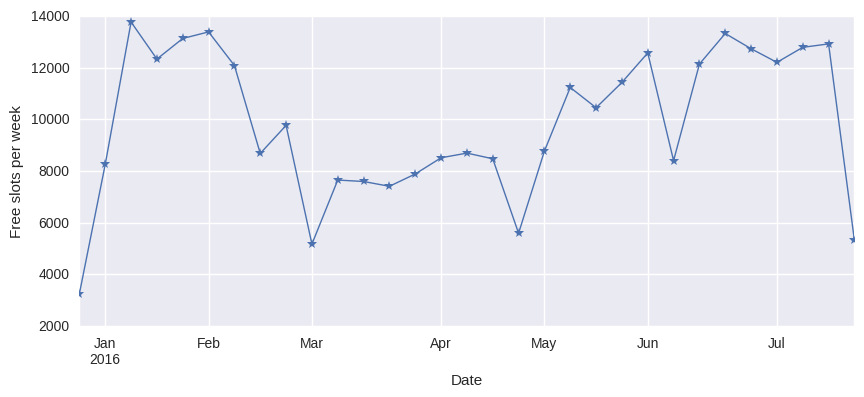

In [12]:
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)

reset_res_2016 = reset_res[reset_res.index >= pd.Timestamp('2015-12-30')]
freeSeries_2016 = pd.Series(reset_res_2016["FREE"]).sort_index()
freeSeries_2016 = pd.rolling_mean(freeSeries_2016, window=MOVING_AVERAGE_WINDOW)
pd_ax = freeSeries_2016.plot(ax=ax, style='*-', label='first line', linewidth=1)

pd_ax.set_xlabel(u'Date')
pd_ax.set_ylabel(u'Free slots per week')

### Предсказание по кустам

In [80]:
def group_by_global_trend(global_trend_series):
    temp_gr = pd.DataFrame({'VALUES': global_trend_series.values, 'INDEX': global_trend_series.index})
    temp_gr['DATE_NO_YEAR'] = temp_gr['INDEX'].map(lambda x: pd.Timestamp('2015-01-01'))
    
    
def get_global_trend_from_train(df_agg_train):
    MOVING_AVERAGE_WINDOW = 3
    freeSeries_temp = pd.Series(df_agg_train["FREE"]).sort_index()
    freeSeries_temp = pd.rolling_mean(freeSeries_temp, window=MOVING_AVERAGE_WINDOW)
    return freeSeries_temp

def get_real_series_kust(df, kust_id):
    temp = df[df['KUST_ID'] == kust_id]
    aggregated = temp.groupby('DATE_WEEK').agg({'TOTAL': lambda x: np.sum(x), 'BUSY': lambda x: np.sum(x)})
    aggregated['FREE'] = aggregated['TOTAL'] - aggregated['BUSY']
    return aggregated['FREE'].sort_index()

def get_kust_thread_train(kust_id, df_agg_train, df_train):
    df_local = df_train[df_train["KUST_ID"] == kust_id]
    agg_local = df_local.groupby('DATE_WEEK').agg({'TOTAL': lambda x: np.sum(x),
                              'BUSY': lambda x: np.sum(x)})
    
    agg_local['FREE_PERCENT'] = (agg_local['TOTAL'] - agg_local['BUSY']) / agg_local['TOTAL']
    agg_local['FREE'] = agg_local['TOTAL'] - agg_local['BUSY']
    agg_local = agg_local.reset_index()
    agg_local.index = agg_local.DATE_WEEK
    
    final_res = df_agg_train.join(agg_local, rsuffix='_exact')
    final_res['THREAD_PORTION'] = final_res['FREE_exact'] / final_res['FREE']
    final_res = final_res.fillna(0)
    
    testSeries_portion = pd.TimeSeries(final_res["THREAD_PORTION"]).sort_index()
    
    return testSeries_portion

def get_prediction_global_trend(global_trend_series, kust_flow_series, start_date, end_date): 
    # start_date должна быть началом недельного блока
    nearest_date = pd.Timestamp(start_date)
    dates_set = kust_flow_series.index
    while nearest_date - timedelta(days=364) not in dates_set:
        nearest_date += timedelta(days=1)
    
    temp_index = pd.date_range(nearest_date - timedelta(days=364), pd.Timestamp(end_date) -timedelta(days=364), freq='7D')
    print temp_index
    a_mean = pd.ewma(kust_flow_series, halflife=3)
    by_smoothed = a_mean[-1]
    
    predicted_values = [by_smoothed] * len(temp_index)
    predicted_timeseries = pd.TimeSeries(predicted_values, index=temp_index)
    output_data = predicted_timeseries * global_trend_series.loc[temp_index]
    output_data.index = temp_index + timedelta(days=364)
    return output_data

def compare_quality(s1, s2, start, end):
    s1_temp = s1[(s1.index >= pd.Timestamp(start)) & (pd.Timestamp(end) > s1.index )]
    s2_temp = s2[(s2.index >= pd.Timestamp(start)) & (pd.Timestamp(end) > s2.index )]
    
    s1_list = [s1_temp[0]]
    for i in range(1, len(s1_temp)):
        s1_list.append(s1_list[i-1] + s1_temp[i])
        
    s2_list = [s2_temp[0]]
    for i in range(1, len(s2_temp)):
        s2_list.append(s2_list[i-1] + s2_temp[i])
    out_series_1 = pd.TimeSeries(s1_list, index=s1_temp.index)
    out_series_2 = pd.TimeSeries(s2_list, index=s2_temp.index)
    return out_series_1, out_series_2

In [91]:
prediction_start_date = '2016-03-05'
prediction_end_date = '2016-07-29'

### Предсказания для 145 куста

DatetimeIndex(['2015-03-12', '2015-03-19', '2015-03-26', '2015-04-02',
               '2015-04-09', '2015-04-16', '2015-04-23', '2015-04-30',
               '2015-05-07', '2015-05-14', '2015-05-21', '2015-05-28',
               '2015-06-04', '2015-06-11', '2015-06-18', '2015-06-25',
               '2015-07-02', '2015-07-09', '2015-07-16', '2015-07-23',
               '2015-07-30'],
              dtype='datetime64[ns]', freq='7D')


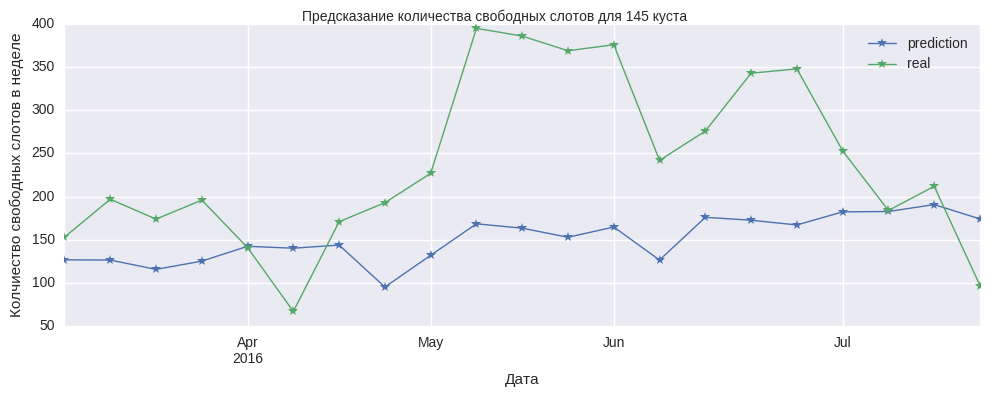

In [143]:
kust_1 = 145
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
a = get_kust_thread_train(kust_1, reset_res_train, df_train )

tr = (reset_res_train['FREE'])

# a_mean = pd.ewma(a, halflife=3)
# prediction_by_smoothed = a_mean[-1]
a_res_pred = get_prediction_global_trend(tr, a, prediction_start_date, prediction_end_date)

a_res_pred.plot(ax=ax, style='*-', label='first line', linewidth=1)
real = get_real_series_kust(df_test, kust_1)[prediction_start_date:prediction_end_date]
real.plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['prediction', 'real'])
ax.set_ylabel(u'Колчиество свободных слотов в неделе')
ax.set_xlabel(u'Дата')
plt.suptitle(u'Предсказание количества свободных слотов для 145 куста')
plt.savefig('./GRAPHS/kust_145_prediction.png')

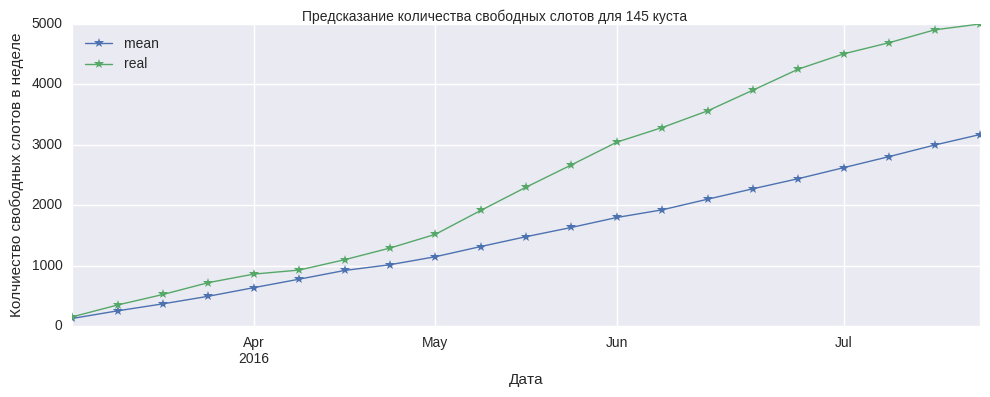

In [144]:
a, b = compare_quality(a_res_pred, real, prediction_start_date, prediction_end_date)
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
pd.TimeSeries(a).plot(ax=ax, style='*-', label='first line', linewidth=1)
pd.TimeSeries(b).plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['mean', 'real'],loc=2)

ax.set_ylabel(u'Колчиество свободных слотов в неделе')
ax.set_xlabel(u'Дата')
plt.suptitle(u'Предсказание количества свободных слотов для 145 куста')
plt.savefig('./GRAPHS/kust_145_flow_realisation.png')

### Предсказания для 10000430 куста

DatetimeIndex(['2015-03-12', '2015-03-19', '2015-03-26', '2015-04-02',
               '2015-04-09', '2015-04-16', '2015-04-23', '2015-04-30',
               '2015-05-07', '2015-05-14', '2015-05-21', '2015-05-28',
               '2015-06-04', '2015-06-11', '2015-06-18', '2015-06-25',
               '2015-07-02', '2015-07-09', '2015-07-16', '2015-07-23',
               '2015-07-30'],
              dtype='datetime64[ns]', freq='7D')


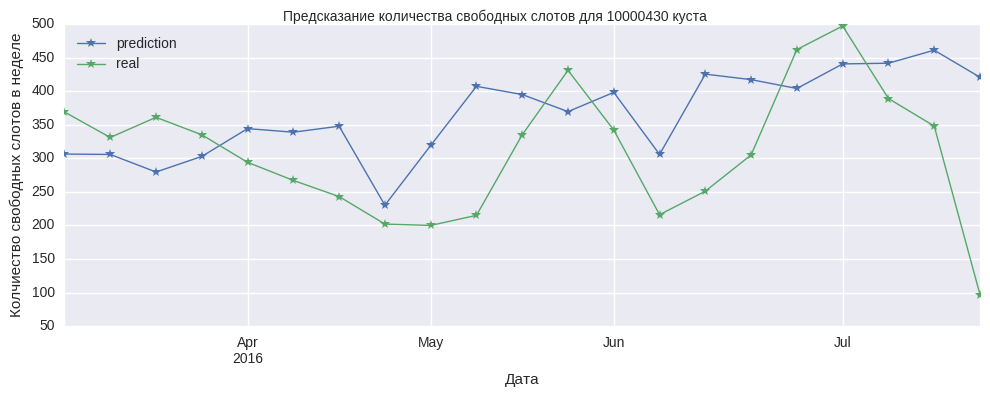

In [145]:
kust_2 = 10000430
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
a = get_kust_thread_train(kust_2, reset_res_train, df_train )

tr = (reset_res_train['FREE'])

# a_mean = pd.ewma(a, halflife=3)
# prediction_by_smoothed = a_mean[-1]
a_res_pred = get_prediction_global_trend(tr, a, prediction_start_date, prediction_end_date)

a_res_pred.plot(ax=ax, style='*-', label='first line', linewidth=1)
real = get_real_series_kust(df_test, kust_2)[prediction_start_date:prediction_end_date]
real.plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['prediction', 'real'], loc=2)
ax.set_ylabel(u'Колчиество свободных слотов в неделе')
ax.set_xlabel(u'Дата')
plt.suptitle(u'Предсказание количества свободных слотов для 10000430 куста')
plt.savefig('./GRAPHS/kust_10000430_prediction.png')

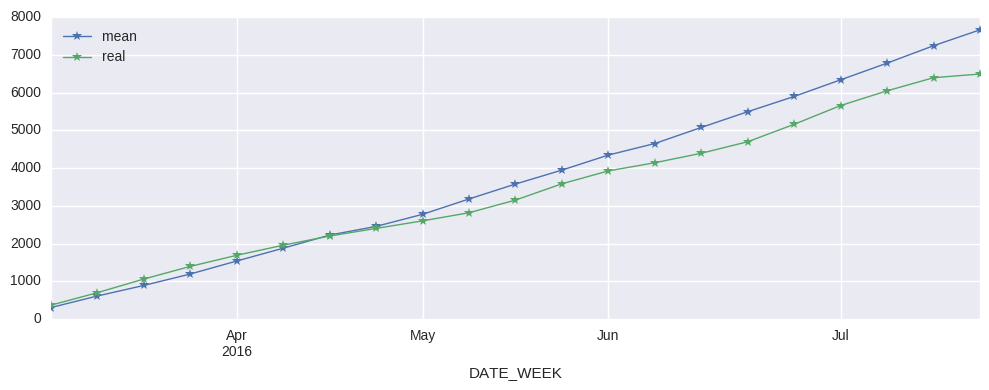

In [146]:
a, b = compare_quality(a_res_pred, real, prediction_start_date, prediction_end_date)
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
pd.TimeSeries(a).plot(ax=ax, style='*-', label='first line', linewidth=1)
pd.TimeSeries(b).plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['mean', 'real'],loc=2)
plt.savefig('./GRAPHS/kust_10000430_flow_realisation.png')

### Предсказания для 10000370 куста

DatetimeIndex(['2015-03-12', '2015-03-19', '2015-03-26', '2015-04-02',
               '2015-04-09', '2015-04-16', '2015-04-23', '2015-04-30',
               '2015-05-07', '2015-05-14', '2015-05-21', '2015-05-28',
               '2015-06-04', '2015-06-11', '2015-06-18', '2015-06-25',
               '2015-07-02', '2015-07-09', '2015-07-16', '2015-07-23',
               '2015-07-30'],
              dtype='datetime64[ns]', freq='7D')


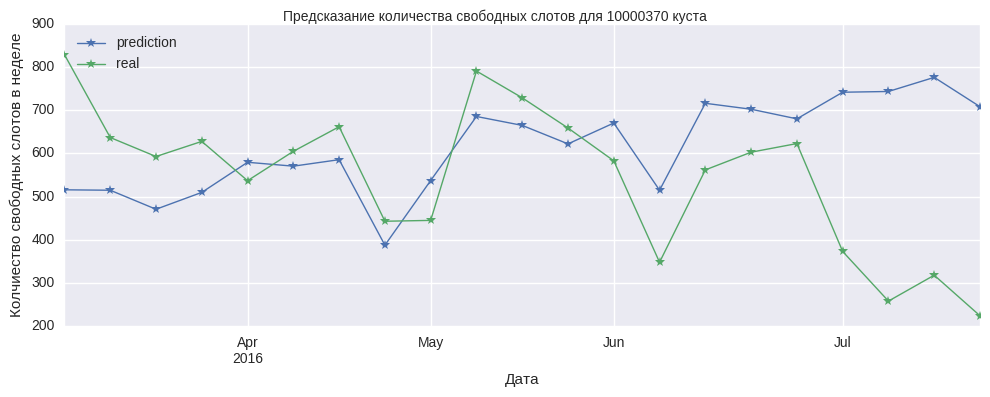

In [147]:
kust_3 = 10000370
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
a = get_kust_thread_train(kust_3, reset_res_train, df_train )

tr = (reset_res_train['FREE'])

# a_mean = pd.ewma(a, halflife=3)
# prediction_by_smoothed = a_mean[-1]
a_res_pred = get_prediction_global_trend(tr, a, prediction_start_date, prediction_end_date)


a_res_pred.plot(ax=ax, style='*-', label='first line', linewidth=1)
real = get_real_series_kust(df_test, kust_3)[prediction_start_date:prediction_end_date]
real.plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['prediction', 'real'], loc=2)
ax.set_ylabel(u'Колчиество свободных слотов в неделе')
ax.set_xlabel(u'Дата')
plt.suptitle(u'Предсказание количества свободных слотов для 10000370 куста')
plt.savefig('./GRAPHS/kust_10000370_prediction.png')

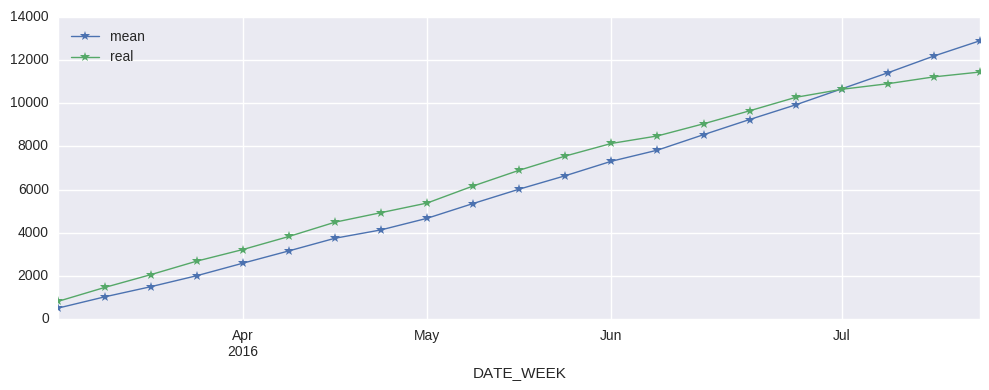

In [148]:
a, b = compare_quality(a_res_pred, real, prediction_start_date, prediction_end_date)
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
pd.TimeSeries(a).plot(ax=ax, style='*-', label='first line', linewidth=1)
pd.TimeSeries(b).plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['mean', 'real'],loc=2)
plt.savefig('./GRAPHS/kust_10000370_flow_realisation.png')

### Предсказания для 204 куста

DatetimeIndex(['2015-03-12', '2015-03-19', '2015-03-26', '2015-04-02',
               '2015-04-09', '2015-04-16', '2015-04-23', '2015-04-30',
               '2015-05-07', '2015-05-14', '2015-05-21', '2015-05-28',
               '2015-06-04', '2015-06-11', '2015-06-18', '2015-06-25',
               '2015-07-02', '2015-07-09', '2015-07-16', '2015-07-23',
               '2015-07-30'],
              dtype='datetime64[ns]', freq='7D')


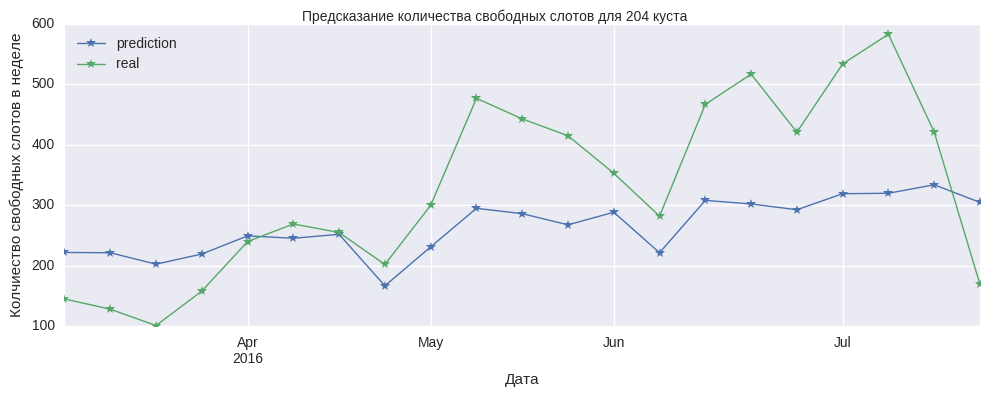

In [149]:
kust_4 = 204
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
a = get_kust_thread_train(kust_4, reset_res_train, df_train )

tr = (reset_res_train['FREE'])

# a_mean = pd.ewma(a, halflife=3)
# prediction_by_smoothed = a_mean[-1]
a_res_pred = get_prediction_global_trend(tr, a, prediction_start_date, prediction_end_date)


a_res_pred.plot(ax=ax, style='*-', label='first line', linewidth=1)
real = get_real_series_kust(df_test, kust_4)[prediction_start_date:prediction_end_date]
real.plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['prediction', 'real'], loc=2)
ax.set_ylabel(u'Колчиество свободных слотов в неделе')
ax.set_xlabel(u'Дата')
plt.suptitle(u'Предсказание количества свободных слотов для 204 куста')
plt.savefig('./GRAPHS/kust_204_prediction.png')

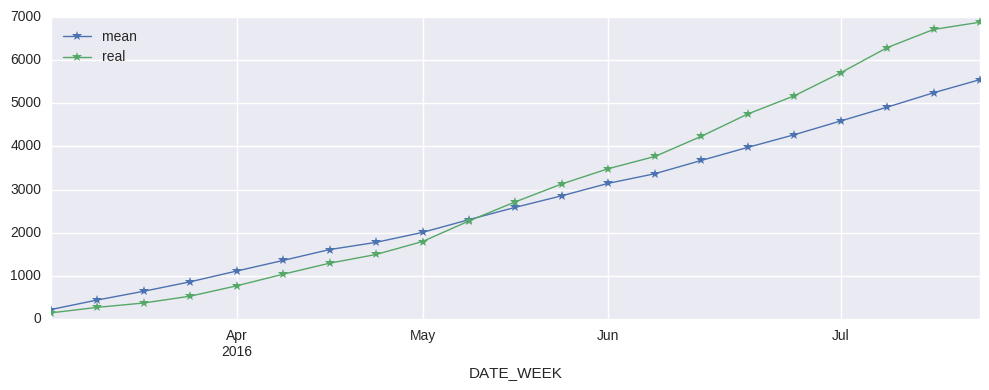

In [150]:
a, b = compare_quality(a_res_pred, real, prediction_start_date, prediction_end_date)
ax = plt.figure(figsize=(10,4), dpi=300).add_subplot(111)
pd.TimeSeries(a).plot(ax=ax, style='*-', label='first line', linewidth=1)
pd.TimeSeries(b).plot(ax=ax, style='*-', label='first line', linewidth=1)
ax.legend(['mean', 'real'],loc=2)
plt.savefig('./GRAPHS/kust_204_flow_realisation.png')

#### Старый вариант

In [116]:
def get_kust_thread_portion_week(kust_id, df_temp, reset_res_temp):
    df_local = df_temp[df_temp["KUST_ID"] == kust_id]
    gr_local = df_local.groupby('DATE_WEEK')
    res_local = gr_local.agg({'TOTAL': lambda x: np.sum(x),
                              'BUSY': lambda x: np.sum(x) })
    res_local['FREE_PERCENT'] = (res_local['TOTAL'] - res_local['BUSY']) / res_local['TOTAL']
    res_local['FREE'] = res_local['TOTAL'] - res_local['BUSY']
    reset_res_local = res_local.reset_index()
#     print reset_res_local
    reset_res_local.index = reset_res_local.DATE_WEEK
    
    final_res = reset_res_temp.join(reset_res_local, rsuffix='_exact')
    final_res['THREAD_PORTION'] = final_res['FREE_exact'] / final_res['FREE']
    final_res = final_res.fillna(0)
    
    testSeries_portion = pd.Series(final_res["THREAD_PORTION"]).sort_index()
    
    return testSeries_portion


def get_prediction_kust(kust_id, kust_series,start='2016-01-01', end='2016-08-15'):
    kust_series_prediction = kust_series.copy()
    kust_series_prediction.index = kust_series.index.map(lambda x: x + timedelta(days=364))
    global_trend = freeSeries_2015.copy()
    global_trend.index = freeSeries_2015.index.map(lambda x: x + timedelta(days=364))
    
    return kust_series_prediction * global_trend

def make_arma_prediction(data):
    data_arma = data[data.index < pd.Timestamp('2016-03-21')]
    data_arma = data_arma.sort_index()
    arma_mod = sm.tsa.ARMA(data_arma, (3,3)).fit()
    return arma_mod.predict(data_arma.index[-1], '2016-08-01', dynamic=True)


In [117]:
kust_ids_all = np.array(sorted(df_train.KUST_ID.unique()))
kust_ids_all_test = np.array(sorted(df_test.KUST_ID.unique()))
kust_series = {k: pd.rolling_mean(get_kust_thread_portion_week(k, df_train, reset_res_train), window=MOVING_AVERAGE_WINDOW)
               for k in kust_ids_all}

kust_series_test = {k: pd.rolling_mean(get_kust_thread_portion_week(k, df_test, reset_res_test), window=MOVING_AVERAGE_WINDOW)
               for k in kust_ids_all_test}